url :

https://www.saab.com/newsroom/press-releases

In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd,requests,bs4,re,time,io,pytesseract,easyocr,random,textstat,urllib.request
from pdfminer.high_level import extract_text
from PIL import Image
from pathlib import Path
from pdf2image import convert_from_path
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from goose3 import Goose
from datetime import datetime
from bs4 import BeautifulSoup
from selenium import webdriver
from tqdm.auto import tqdm

reader = easyocr.Reader(['en'])

import warnings
warnings.filterwarnings("ignore")

%autosave 1

Autosaving every 1 seconds


In [2]:
#driver for operation
from webdriver_manager.chrome import ChromeDriverManager
option = webdriver.ChromeOptions()
# option.add_argument('headless')
driver = webdriver.Chrome(ChromeDriverManager().install(),options=option)



====== WebDriver manager ======
Current google-chrome version is 102.0.5005
Get LATEST chromedriver version for 102.0.5005 google-chrome
Driver [C:\Users\AKSHAY SATPUTE\.wdm\drivers\chromedriver\win32\102.0.5005.61\chromedriver.exe] found in cache


In [3]:
SITE_NAME='SAAB'

DOMAIN = "https://www.saab.com"

SITE_LINK="https://www.saab.com/newsroom/press-releases"

In [4]:
def parse_webpage_bs(search_url):
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:90.0) Gecko/20100101 Firefox/90.0"}
    try:
        site_request = requests.get(search_url, headers=headers, timeout=10)
    except requests.exceptions.RequestException as e:
        print(e)
        site_request = None
    if site_request != None and site_request.status_code==200:
        site_soup = bs4.BeautifulSoup(site_request.content, "lxml")
    else:
        site_soup = None
    return site_soup

def remove_esc_chars(text):
    return text.replace("\n", " ").replace("\t", " ").replace("\r", " ")

def get_text_thumb(link): 
    try:
        driver.get(link)
        thumb = driver.find_element(By.XPATH,f'''//img[@data-resp-img]''').get_attribute("src")
        ps = driver.find_element(By.XPATH,f'''//div[@class="article-mainbody"]''').text.strip()
        text = remove_esc_chars(ps).strip()
    except:
        thumb = "https://res.cloudinary.com/dkkd45ayz/image/upload/f_auto,q_auto,dpr_auto/w_535,h_535,c_fill,g_auto/w_421,h_421,c_scale/episerver/fff5e08e-5b0c-45b5-8d76-8fb14f12e142/20220531-en-4278237-1.png"
        g = Goose()
        article_extract = g.extract(url=link)
        article = remove_esc_chars(article_extract.cleaned_text)
        meta_data = remove_esc_chars(article_extract.meta_description)
        whole_data = meta_data+article
        text = whole_data.strip()

        if textstat.lexicon_count(text, removepunct=True) < 5:
            try:
                response = requests.get(link)
                text = remove_esc_chars(extract_text(io.BytesIO(response.content)))

                if textstat.lexicon_count(text, removepunct=True) < 5:
                    texts = ""
                    r = requests.get(link)
                    filename = Path('temp.pdf')
                    filename.write_bytes(r.content)

                    pages = convert_from_path('temp.pdf', 500)
                    for x in pages:
                        x.save("temp.jpg")
                        output = reader.readtext("temp.jpg")
                        for o in output:
                            texts += o[1]

                    text = remove_esc_chars(texts)

                    if textstat.lexicon_count(text, removepunct=True) < 5:
                        texts = ""
                        soup = parse_webpage_bs(link)
                        if soup!= None:
                            ps = soup.findAll('p')
                            for p in ps:
                                texts+= p.text

                        text = remove_esc_chars(texts)
            except:
                text = ""
    
    return text , thumb

def scroll(fact = 200):
    
    driver.find_element_by_tag_name('body').send_keys(Keys.CONTROL + Keys.HOME)
    
    # Get scroll height
    last_height = driver.execute_script("return document.body.scrollHeight")
    
    #scrolling litle bit acording to height
    for x in tqdm(range(round(last_height/fact)+1),desc ="Scrolling"):
        driver.execute_script(f"window.scrollTo(0, window.scrollY + {fact})")
        time.sleep(.1)

last_page_url = https://www.saab.com/newsroom/press-releases#468493_year__quarter__query__language_en_skip_2170

In [5]:
article_list = []

url = SITE_LINK
driver.get(url)
    
time.sleep(1)
#accepting cookies
try:
    driver.find_element_by_xpath('''//*[@id="CybotCookiebotDialogBodyLevelButtonLevelOptinAllowAll"]''').click()
except:
    pass

#getting last apge
try:
    for x in tqdm(range(10),desc ="Getting whole page"):
        driver.find_element_by_xpath('''//button[@class="btn-outline btn-outline-blue"]''').click()
        time.sleep(1)
except:
    pass
                
#elements container
elements = driver.find_elements(By.XPATH,'''//div[@class="item"]''')

#creating empty lists to append data 
published_dates,titles,texts,links,thumbnails,authors = [],[],[],[],[],[]

#published_dates,titles,links,authors
for e in tqdm(range(1,len(elements[:100])),desc ="Getting urls"):
    title = driver.find_element(By.XPATH,f'''//*[@id="primarycontent"]/div/div/div[2]/div[2]/div[2]/div[{e}]/div[3]/a''').text.strip()
    titles.append(title)
    published_date = driver.find_element(By.XPATH,f'''//*[@id="primarycontent"]/div/div/div[2]/div[2]/div[2]/div[{e}]/div[1]/div[2]''').text.strip()
    published_dates.append(published_date)
    link = driver.find_element(By.XPATH,f'''//*[@id="primarycontent"]/div/div/div[2]/div[2]/div[2]/div[{e}]/div[3]/a''').get_attribute("href")
    links.append(link)
    authors.append(SITE_NAME)

#texts,thumbnails
for link in tqdm((links[:21]),desc ="Getting articles"):
    text , thumbnail = get_text_thumb(link)
    texts.append(text)
    thumbnails.append(thumbnail)
    
#zippig all the data togather 
zipped = list(zip(published_dates,titles,texts,links,thumbnails,authors))

#unwinding and appending to the main list
for published_date,title,text,link,thumbnail,author in zipped:
    article = (published_date.strip(),title.strip(),text.strip(),link.strip(),thumbnail.strip(),author.strip())
    article_list.append(article)
    print(published_date,title)

Getting whole page:   0%|          | 0/10 [00:00<?, ?it/s]

Getting urls:   0%|          | 0/79 [00:00<?, ?it/s]

Getting articles:   0%|          | 0/21 [00:00<?, ?it/s]

1 June 2022 Saab Receives Order for Studies on Future Fighter Aircraft Development
31 May 2022 Saab to Divest Laser Rangefinder Business
27 May 2022 Saab Receives Orders for Carl-Gustaf Components
24 May 2022 Saab Receives Swedish Order for Torpedo Tubes for Surface Ships
12 May 2022 Saab Awarded Contract from US Army for Carl-Gustaf recoilless rifles
12 May 2022 Viktor Wallström New Head of Group Communication at Saab
10 May 2022 Saab’s Sirius Compact Offers New Flexibility for EW Users
10 May 2022 Saab Receives Order from Sweden for Carl-Gustaf Ammunition
6 May 2022 Saab Firings Showcase New Programmable Carl-Gustaf Munition
5 May 2022 Denmark Becomes 15[th] Carl-Gustaf M4 Customer
28 April 2022 Roll-Out of EMD-phase T-7A Red Hawk Aircraft
26 April 2022 Saab and FMV Sign Contract for new Gripen Launch System
22 April 2022 Saab’s Results January-March 2022: A solid start to the year in a changing landscape
11 April 2022 Saab Receives Order for Gripen C/D Upgrade
8 April 2022 Invitatio

In [6]:
temp_df = pd.DataFrame(article_list,columns=['date','title','article','url','thumbnail','author'])
temp_df

,date,title,article,url,thumbnail,author
0,1 June 2022,Saab Receives Order for Studies on Future Figh...,The study is preparatory in nature and its pur...,https://www.saab.com/newsroom/press-releases/2...,https://res.cloudinary.com/dkkd45ayz/image/upl...,SAAB
1,31 May 2022,Saab to Divest Laser Rangefinder Business,"The transaction, which was signed in March 202...",https://www.saab.com/newsroom/press-releases/2...,https://res.cloudinary.com/dkkd45ayz/image/upl...,SAAB
2,27 May 2022,Saab Receives Orders for Carl-Gustaf Components,"The industry’s nature is such that, depending ...",https://www.saab.com/newsroom/press-releases/2...,https://res.cloudinary.com/dkkd45ayz/image/upl...,SAAB
3,24 May 2022,Saab Receives Swedish Order for Torpedo Tubes ...,The new torpedo tube will have the customer de...,https://www.saab.com/newsroom/press-releases/2...,https://res.cloudinary.com/dkkd45ayz/image/upl...,SAAB
4,12 May 2022,Saab Awarded Contract from US Army for Carl-Gu...,Saab will provide Carl-Gustaf recoilless rifle...,https://www.saab.com/newsroom/press-releases/2...,https://res.cloudinary.com/dkkd45ayz/image/upl...,SAAB
5,12 May 2022,Viktor Wallström New Head of Group Communicati...,Viktor Wallström is currently Executive Vice P...,https://www.saab.com/newsroom/press-releases/2...,https://res.cloudinary.com/dkkd45ayz/image/upl...,SAAB
6,10 May 2022,Saab’s Sirius Compact Offers New Flexibility f...,Sirius Compact brings new capabilities thanks ...,https://www.saab.com/newsroom/press-releases/2...,https://res.cloudinary.com/dkkd45ayz/image/upl...,SAAB
7,10 May 2022,Saab Receives Order from Sweden for Carl-Gusta...,The order is placed within a framework agreeme...,https://www.saab.com/newsroom/press-releases/2...,https://res.cloudinary.com/dkkd45ayz/image/upl...,SAAB
8,6 May 2022,Saab Firings Showcase New Programmable Carl-Gu...,The firings took place 3-4 May 2022 in front o...,https://www.saab.com/newsroom/press-releases/2...,https://res.cloudinary.com/dkkd45ayz/image/upl...,SAAB
9,5 May 2022,Denmark Becomes 15[th] Carl-Gustaf M4 Customer,The recoilless Carl-Gustaf M4 weapon increases...,https://www.saab.com/newsroom/press-releases/2...,https://res.cloudinary.com/dkkd45ayz/image/upl...,SAAB


21 March 2022 Saab Delivers Next Generation AIS Ship Transponders Supporting VDES to Sternula

SAAB https://www.saab.com/newsroom/press-releases/2022/saab-delivers-next-generation-ais-ship-transponders-supporting-vdes-to-sternula


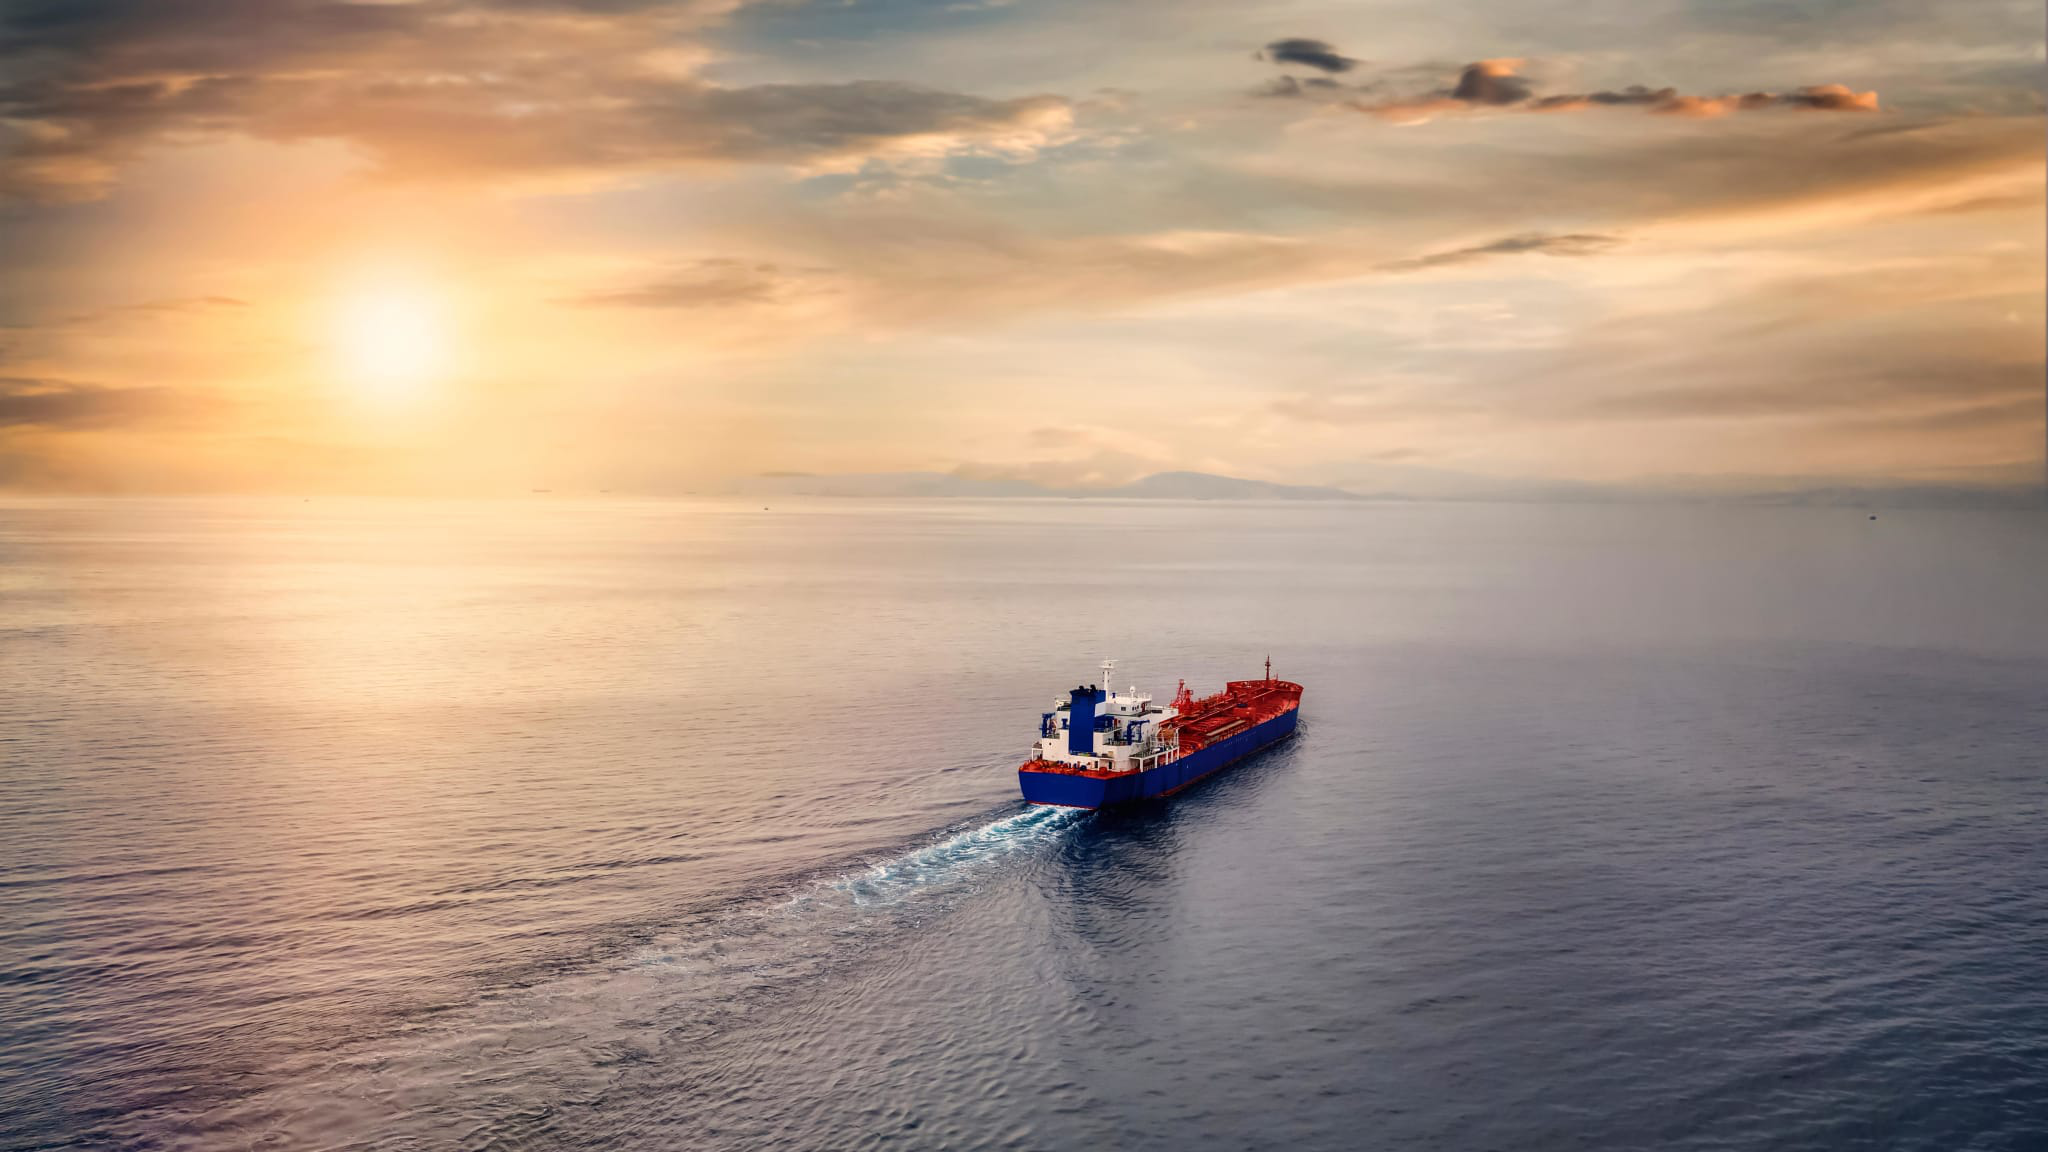


The R6 Supreme AIS/VDES transponders will be type approved to the Class-A AIS standard and provide functionality to the next generation of global maritime communication services based on a VHF VDES. The deliveries of transponders will occur from March 2022 to January 2023, including both terrestrial and satellite VDES functionality. “The innovative VDES technology is gradually becoming established as the next generation of AIS. VDES will increase the maritime safety and contribute to a greener shipping industry.”, says Johanna Gustafsson”, Head of Transpondertech at Saab “AIS 2.0 will be much more than just ship tracking. It will be a true revolution to maritime digitalization. For the rest of this decade, the technology will enable a shift from today’s manual administrative processes to a highly automated maritime industry. We are very excited that we will be working with Saab, one of the pioneers in AIS, in our upcoming VDES pilot projects”, says Lars Moltsen, Founder and CEO of Ste

In [7]:
def see_data(iloc_no=random.randint(0,len(temp_df))-1):
    print(temp_df.iloc[iloc_no]['date'],temp_df.iloc[iloc_no]['title'])
    print(f"\n{temp_df.iloc[iloc_no]['author']} {temp_df.iloc[iloc_no]['url']}")
    urllib.request.urlretrieve(temp_df.iloc[iloc_no]['thumbnail'], "temp.jpg")
    display(Image.open("temp.jpg"))
    print(f"\n{temp_df.iloc[iloc_no]['article']}")

see_data()

In [8]:
#to csv
temp_df.to_csv(f'{SITE_NAME} news.csv',index = False)

#to json
temp_df.to_json(f'{SITE_NAME} news.json')

In [9]:
#to get rid of unwanteed trash created by the model use 
def remove_trash():
    try:
        try:
            os.remove("temp.pdf")
        except:
            pass
        os.remove("temp.jpg")
        print("Trash removed successfully")
    except:
        print("No trash found")

remove_trash()

Trash removed successfully
